# Wildfire Path Project (Exploration)
The first dataset we utilize is presented as a kaggle competition here: https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires

## Context from kaggle
"This data publication contains a spatial database of wildfires that occurred in the United States from 1992 to 2015. It is the third update of a publication originally generated to support the national Fire Program Analysis (FPA) system. The wildfire records were acquired from the reporting systems of federal, state, and local fire organizations. The following core data elements were required for records to be included in this data publication: discovery date, final fire size, and a point location at least as precise as Public Land Survey System (PLSS) section (1-square mile grid). The data were transformed to conform, when possible, to the data standards of the National Wildfire Coordinating Group (NWCG). Basic error-checking was performed and redundant records were identified and removed, to the degree possible. The resulting product, referred to as the Fire Program Analysis fire-occurrence database (FPA FOD), includes 1.88 million geo-referenced wildfire records, representing a total of 140 million acres burned during the 24-year period."



In [69]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split

In [2]:
cnx = sqlite3.connect('data/FPA_FOD_20170508.sqlite')

In [5]:
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE, FIRE_SIZE_CLASS, FIRE_SIZE FROM 'Fires'", cnx)
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
df_orig = df.copy()
print(df.head()) 

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

  FIRE_SIZE_CLASS  FIRE_SIZE       DATE  MONTH DAY_OF_WEEK  
0               A       0.10 2005-02-02      2   Wednesday  
1               A       0.25 2004-05-12      5   Wednesday  
2               A       0.10 2004-05-31      5      Monday  
3               A       0.10 2004-06-28      6      Monday  
4               A       0.10 2004-06-28      6      Monday  


## Timeline of data
Here we look at the spread of fire data - we know that VIIRS data from remote sensing begins circa 2012, so we will focus on that section.

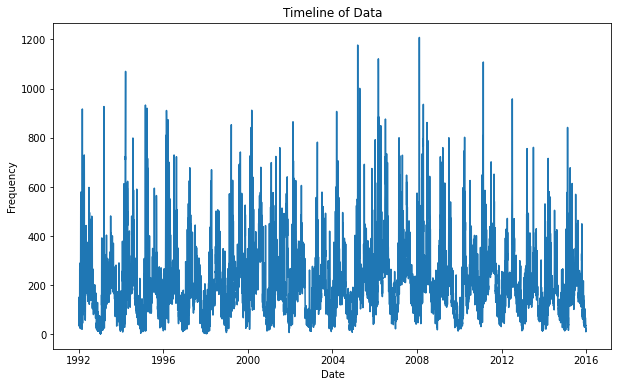

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df['DATE'] = pd.to_datetime(df['DATE'])

date_counts = df.resample('D', on='DATE').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.lineplot(x='DATE', y='count', data=date_counts)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Timeline of Data')
plt.show()


We also use the fire size class field to only choose large fires (class G and F) to start. These should be the easiest to map using VIIRS, and also the fires we want to fit to.

In [7]:
big_fires_recent = df[(df['FIRE_SIZE_CLASS'].isin(['G','F'])) & (df['FIRE_YEAR'] > 2012)]

### Wildfire VIIRS 375m NRT files
VIIRS Active Fire and Thermal Anomalies product from S-NPP processed by LANCE / FIRMS

![image](viirs_vs_modis.png)

| Attribute   | Short Description               | Long Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
|-------------|---------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Latitude    | Latitude                        | Center of nominal 375 m fire pixel.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| Longitude   | Longitude                       | Center of nominal 375 m fire pixel.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| Bright_ti4  | Brightness temperature I-4      | VIIRS I-4 channel brightness temperature of the fire pixel measured in Kelvin.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| Scan        | Along Scan pixel size           | The algorithm produces approximately 375 m pixels at nadir. Scan and track reflect actual pixel size.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| Track       | Along Track pixel size          | The algorithm produces approximately 375 m pixels at nadir. Scan and track reflect actual pixel size.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| Acq_Date    | Acquisition Date                | Date of VIIRS acquisition.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| Acq_Time    | Acquisition Time                | Time of acquisition/overpass of the satellite (in UTC).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| Satellite   | Satellite                       | N= Suomi National Polar-orbiting Partnership (Suomi NPP).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| Confidence  | Confidence                      | This value is based on a collection of intermediate algorithm quantities used in the detection process. It is intended to help users gauge the quality of individual hotspot/fire pixels. Confidence values are set to low, nominal, and high. Low confidence daytime fire pixels are typically associated with areas of Sun glint and lower relative temperature anomaly (<15 K) in the mid-infrared channel I4. Nominal confidence pixels are those free of potential Sun glint contamination during the day and marked by strong (>15 K) temperature anomaly in either day or nighttime data. High confidence fire pixels are associated with day or nighttime saturated pixels. Please note: Low confidence nighttime pixels occur only over the geographic area extending from 11° E to 110° W and 7° N to 55° S. This area describes the region of influence of the South Atlantic Magnetic Anomaly which can cause spurious brightness temperatures in the mid-infrared channel I4 leading to potential false positive alarms. These have been removed from the NRT data distributed by FIRMS. |
| Version     | Version (collection and source) | Version identifies the collection (e.g., VIIRS Collection 1 or VIIRS Collection 2), and source of data processing (Ultra Real-Time (URT suffix added to collection), Real-Time (RT suffix), Near Real-Time (NRT suffix) or Standard Processing (collection only). For example: "2.0URT" - Collection 2 Ultra Real-Time processing. "2.0RT" - Collection 2 Real-Time processing. "1.0NRT" - Collection 1 Near Real-Time processing. "1.0" - Collection 1 Standard processing.                                                                                                                                                                                        |
| Bright_ti5  | Brightness temperature I-5      | I-5 Channel brightness temperature of the fire pixel measured in Kelvin.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| FRP         | Fire Radiative Power            | FRP depicts the pixel-integrated fire radiative power in megawatts (MW). Given the unique spatial and spectral resolution of the data, the VIIRS 375 m fire detection algorithm was customized and tuned to optimize its response over small fires while balancing the occurrence of false alarms. Frequent saturation of the mid-infrared I4 channel (3.55-3.93 µm) driving the detection of active fires requires additional tests and procedures to avoid pixel classification errors. As a result, sub-pixel fire characterization (e.g., fire radiative power [FRP] retrieval) is only viable across small and/or low-intensity fires. Systematic FRP retrievals are based on a hybrid approach combining 375 and 750 m data. In fact, starting in 2015 the algorithm incorporated additional VIIRS channel M13 (3.973-4.128 µm) 750 m data in both aggregated and unaggregated format. |
| Type*       | Inferred hot spot type           | 0 = presumed vegetation fire 1 = active volcano 2 = other static land source 3 = offshore detection (includes all detections over water)                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| DayNight    | Day or Night                    | D= Daytime fire, N= Nighttime fire                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |


The VIIRS data is delivered as an annotated shapefile, which we can load in using geopandas.

In [11]:
import geopandas as gpd

filepath = "data/fire_archive_SV-C2_384946.shp"

gdf = gpd.read_file(filepath)
print(gdf.head())

    LATITUDE   LONGITUDE  BRIGHTNESS  SCAN  TRACK    ACQ_DATE ACQ_TIME  \
0  19.390509 -155.106186      333.44  0.54   0.51  2013-01-08     0000   
1  19.403856 -155.281113      367.00  0.52   0.50  2013-01-08     0000   
2  19.408466 -155.281723      328.19  0.52   0.50  2013-01-08     0000   
3  46.519413  -84.377098      332.92  0.46   0.39  2013-01-08     0718   
4  42.953724  -76.572639      312.89  0.47   0.39  2013-01-08     0718   

  SATELLITE INSTRUMENT CONFIDENCE VERSION  BRIGHT_T31    FRP DAYNIGHT  TYPE  \
0         N      VIIRS          n       1      293.81   3.08        D     2   
1         N      VIIRS          l       1      329.03  79.79        D     1   
2         N      VIIRS          l       1      302.60  79.79        D     1   
3         N      VIIRS          n       1      265.78   8.04        N     3   
4         N      VIIRS          n       1      269.03   1.51        N     0   

                      geometry  
0  POINT (-155.10619 19.39051)  
1  POINT (-155

It includes a field for sorting by type - we are most interested in vegetation fires.

In [12]:
len(gdf[gdf.TYPE == 0])
gdf = gdf[gdf.TYPE == 0]

1095785

## Joining the two data sources
We will use the spatial join from geopandas to try and join recorded fire points from the kaggle 1.88 million US wildfires dataset to the associated VIIRS measurements
### Potential improvements
This is a sketch of the process - we should be more careful about this filtering job.

In [13]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

big_fires_recent['DATE'] = pd.to_datetime(big_fires_recent['DATE'])
gdf['ACQ_DATE'] = pd.to_datetime(gdf['ACQ_DATE'])

geometry_big_fires = [Point(xy) for xy in zip(big_fires_recent.LONGITUDE, big_fires_recent.LATITUDE)]
geometry_gdf = [Point(xy) for xy in zip(gdf.LONGITUDE, gdf.LATITUDE)]

geo_big_fires_recent = gpd.GeoDataFrame(big_fires_recent, geometry=geometry_big_fires)
geo_gdf = gpd.GeoDataFrame(gdf, geometry=geometry_gdf)

# ensure both GeoDataFrames have the same crs
geo_big_fires_recent.crs = geo_gdf.crs


/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_13476/2940107774.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_fires_recent['DATE'] = pd.to_datetime(big_fires_recent['DATE'])


In [14]:
# reproject GeoDataFrames to a suitable CRS in meters (e.g., UTM)
geo_big_fires_recent = geo_big_fires_recent.to_crs(epsg='9822')
geo_gdf = geo_gdf.to_crs(epsg='9822')

# create a buffer of 5 km around each point in geo_big_fires_recent
geo_big_fires_recent['geometry'] = geo_big_fires_recent.buffer(5000)  # 5 km in meters

# spatial join
joined_gdf = gpd.sjoin(geo_gdf, geo_big_fires_recent, how='inner', op='intersects')

# TODO: This recency filtering is arbitrary - improve
# filter rows where the date difference is within 3 days
result_gdf = joined_gdf[joined_gdf['ACQ_DATE'].sub(joined_gdf['DATE']).abs().dt.days <= 3]


/Users/lucasrosenblatt/opt/miniconda3/envs/heuristic_fairness/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


<AxesSubplot:>

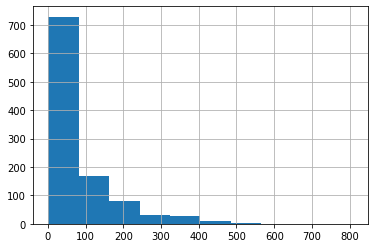

In [17]:
result_gdf.index_right.value_counts().hist()

Now we are plotting the records on a map of US, to spot check. Looks good!

/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_13476/3722407059.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  us = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


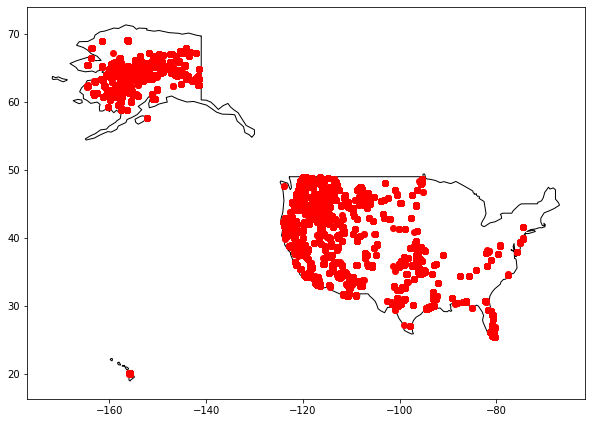

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt

# load the US boundaries (here we use GeoPandas datasets)
us = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us = us[us['name'] == 'United States of America']

# plot the US map
ax = us.plot(figsize=(10, 10), color='white', edgecolor='black')

# plot the points from result_gdf on top
result_gdf.to_crs(us.crs).plot(ax=ax, color='red')

plt.show()

In [19]:
save = False
if save:
    result_gdf.to_file("result_gdf.geojson", driver='GeoJSON')


### Single fire exploration
Here, we try to validate that we can accumulate observations for a single fire in a meaningful way, using a date and our geotagged data.

In [20]:
result_gdf_time_index = result_gdf.set_index(['ACQ_DATE','ACQ_TIME'], inplace=False)

# get the values of the first level of the index
level_0_values = result_gdf_time_index.index.get_level_values(0)

# get the value counts based on the first level of the index
value_counts = level_0_values.value_counts()

# try to isolate a single large fire using a date
fire_1796407 = result_gdf_time_index[result_gdf_time_index['index_right'] == 1796407].loc['2015-06-23']


In [23]:
# get the values of the first level of the index
level_0_values = fire_1796407.index.get_level_values(0)

# get the value counts based on the first level of the index
value_counts = level_0_values.value_counts()

print(value_counts)

2218    49
2036    48
1042    31
0018    21
1900    18
1224     9
1542     9
1400     4
Name: ACQ_TIME, dtype: int64


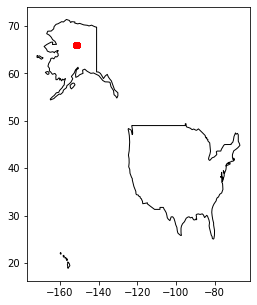

In [31]:
# load the US boundaries (here we use GeoPandas datasets)
ax = us.plot(figsize=(10, 12), color='white', edgecolor='black')

# plot the points from result_gdf on top
fire_1796407.to_crs(us.crs).plot(ax=ax, color='red')

plt.show()

## Attempting to animate fire spread
As a heuristic for how good our data joining is, here we attempt to animate the fire spread across the observation timestamps.

### Note
This demonstrates that there are errors somewhere in the join process...

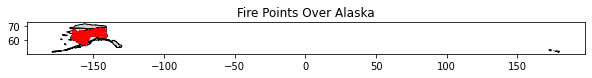

In [55]:
import geopandas as gpd

alaska = gpd.read_file('tl_2018_02_anrc/tl_2018_02_anrc.shp')

import matplotlib.pyplot as plt

fire_1796407_sorted = result_gdf.sort_values(by="ACQ_TIME")
fire_1796407_sorted = fire_1796407_sorted[fire_1796407_sorted['ACQ_DATE'] == '2015-06-23']

geometry = gpd.points_from_xy(fire_1796407_sorted["LONGITUDE_left"], fire_1796407_sorted["LATITUDE_left"])
fire_gdf = gpd.GeoDataFrame(fire_1796407_sorted, geometry=geometry)

# now, plot Alaska and the fire data points
fig, ax = plt.subplots(figsize=(10, 10))

alaska.plot(ax=ax, color='lightgrey', edgecolor='black')
fire_gdf.plot(ax=ax, markersize=10, color='red')

plt.title("Fire Points Over Alaska")
plt.show()


/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_13476/699350895.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  alaska = alaska[alaska.geometry.distance(main_centroid) < threshold]


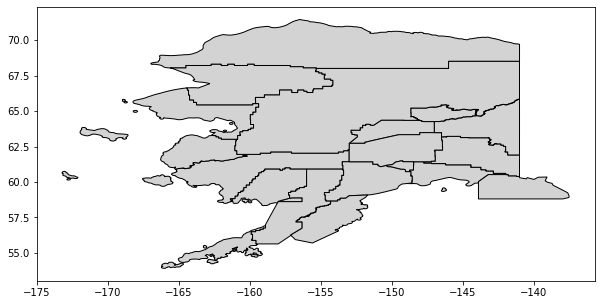

In [64]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

alaska = gpd.read_file('Alaska_Borough_and_Census_Area_Boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp')

main_centroid = alaska.unary_union.centroid

threshold = 10 

alaska = alaska[alaska.geometry.distance(main_centroid) < threshold]

alaska.plot(ax=ax, color='lightgrey', edgecolor='black')

ax.set_aspect('equal', 'box')

plt.show()


In [67]:
import numpy as np

unique_times = np.sort(fire_1796407_sorted["ACQ_TIME"].unique())

for idx, time in enumerate(unique_times):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    alaska.plot(ax=ax, color='lightgrey', edgecolor='black')
    fire_gdf.to_crs(alaska.crs).plot(ax=ax, color='red')
    current_time_data = fire_gdf[fire_gdf["ACQ_TIME"] == time]
    current_time_data.plot(ax=ax, markersize=10, color='red')

    plt.title(f"Fire Points Over Alaska at ACQ_TIME: {time}")
    plt.savefig(f"frame_{idx}.png")
    plt.close() 


In [68]:
import imageio

filenames = [f"frame_{i}.png" for i in range(len(unique_times))]

with imageio.get_writer('animation.gif', mode='I', duration=1000) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_13476/3813639288.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
